## STUDENT NUMBER: 19200191
## COMP41680: DATA SCIENCE WITH PYTHON
### SCRAPPING CONSUMER REVIEWS AND CLASSIFICATION

In [1]:
#Importing required libraries
import os
import requests
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup, SoupStrainer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 1. 

__Select three review categories of your choice. Scrape all reviews for each category and store them as three separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”).__

__Selected Category:__
    1. Automotive
    2. Hotels
    3. Restaurants
    
__a. Main category URL scraping__

In [2]:
#Base URL for the webpage
base_url='http://mlg.ucd.ie/modules/yalp/'

#Storing different categories
categories_url_list = []

base_data = requests.get(base_url)
base_parser = BeautifulSoup(base_data.content,'html.parser')
base_links = base_parser.find_all('a')

for link in base_links:
    #Taking only href tags
    link = link.get('href')
    if 'hotels' in link or 'automotive' in link or 'restaurants' in link:
        categories_url_list.append(base_url+str(link))

print(categories_url_list)

['http://mlg.ucd.ie/modules/yalp/automotive_list.html', 'http://mlg.ucd.ie/modules/yalp/hotels_list.html', 'http://mlg.ucd.ie/modules/yalp/restaurants_list.html']


__b. Methods defined to get review, review links and ratings__

In [3]:
#Return review links
def get_review_links(hyperlinks):
    reviews_url_list=[]
    for link in hyperlinks:
        #to avoid index hyperlink
        if 'index' in link.get('href'):
            pass
        else:
            reviews_url_list.append(base_url+ link.get('href'))
    return(reviews_url_list)

def get_reviews(review_with_tags):
    reviews = []
    for review in review_with_tags:
        reviews.append(review.text)
    #print(reviews)
    return(reviews)

def get_rating(rating_with_tags):
    ratings = []
    for rating in rating_with_tags:
        if int(rating.get('alt')[0])<=3:
            ratings.append('negative')
        else:
            ratings.append('positive')
    return ratings

__c. Scraping the individual category data and creating seperate csv file in localfile system.__

In [4]:
#Fetching review links on the page.
df_idx=0

#A list of different dataframes
dataframe_list = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

for category_url in categories_url_list:
    page = requests.get(category_url)
    parser = BeautifulSoup(page.content, 'html.parser')
    hyperlinks = parser.find_all('a')
    reviews_url = get_review_links(hyperlinks)
    d = {}
    
    if 'automotive' in category_url:
        name = 'automotive'
    elif 'hotels' in category_url:
        name = 'hotels'
    else:
        name = 'restaurants'
        
    for review_url in reviews_url:
        pg = requests.get(review_url)
        review_parser = BeautifulSoup(pg.content, 'html.parser')
        #To extract a particular class inside a tag
        review_with_tags = review_parser.find_all('p',{"class":"review-text"})
        reviews = get_reviews(review_with_tags)

        rating_with_tags = review_parser.find_all('img',alt=True)
        ratings = get_rating(rating_with_tags)
        d = {'Reviews': reviews,'Label':ratings}
        dataframe_list[df_idx] = dataframe_list[df_idx].append(pd.DataFrame(d), ignore_index=True)
        
    dataframe_list[df_idx].to_csv('./collected_data/'+name+'.csv', index=False)
    df_idx += 1

### Task 2.

__For each of the three category datasets:__

__Loading the data into dataframes for ease of processing.__

In [5]:
#Reading all category files into dataframes for easy analysis

#Creating a list of dataframe to store three categories
category_list = [pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
category_list_name = ['Automotive', 'Hotels', 'Restaurants']

root = 'collected_data'
i = 0 
for root, directories, files in os.walk(root):
    for file in files:
        file_path = os.path.join(root,file)
        category_list[i] = category_list[i].append(pd.read_csv(file_path),ignore_index=True)
        i = i+1
category_list[0].head()

,Reviews,Label
0,The man that was working tonight (8-12-17) was...,negative
1,Chris is a very rude person. Gave me an attitu...,negative
2,One of my favorite gas station to stop at. The...,positive
3,Oh thank Heaven for Seven Eleven! I don't know...,negative
4,Five stars because of the guy who works weekda...,positive


__a. From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.__

__Pre-Processing:__

Following pre-processing steps are used on the data:

    1. Lemmatization
    2. Stopword removal
    3. Minimum document frequency
    4. TF-IDF Vectorization

__1. Lemmatization:__

There are two popular approach for finding out the base form of a word:

    i. Stemming 
    ii. Lemmatization
    
The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

However, the two differ in their flavor. __Stemming__ usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. __Lemmatization__ usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

In [6]:
#Method for applying Lemmatization on reviews.
def lemmatize_data(df):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(df)):
        df.loc[i,'Reviews'] = lemmatizer.lemmatize(df.loc[i,'Reviews'])
    return df

In [7]:
#Applying Lemmatization on reviews of all categories.
for i in range(len(category_list)):
    category_list[i] = lemmatize_data(category_list[i])

In [8]:
#Seperating categories into seperate dataframes
df_auto = pd.DataFrame()
df_hotel = category_list[1]
df_restaurant = category_list[2]

__2. StopWord Removal:__

Stop words are basically a set of commonly used words in any language. Determiners(the, an, a), Coordinating conjunctions(for, an, nor, but), Prepositions(in, under, towards, before) are majorly considered as stop words.

Why to remove?
    
* They don't help us to find the context or the true meaning of a sentence. These are words can be removed without any negative consequences to the final model. Also removing these word decreases the dataset size as they are used very frequently and do not convey any meaning.



__3. Minimum Document Frequency:__

`min_df` is used for removing terms that appear too infrequently.

* `min_df` = 0.01 means ignore terms that appear in less than 1% of the documents.

* `min_df = 10` means ignore terms that appear in less than 10 documents.

* The default `min_df is 1`, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

__4. TF-IDF Vectorization:__

`Tf-idf` stands for term frequency-inverse document frequency, and tf-idf weight is a weight mostly used for information extraction and text mining. This weight is a mathematical method used to determine the value of a term in a list or corpus text. Importance decreases in relation to the amount of times a term occurs in the text, which is offset by the occurrence of the term in the corpus.

Rather than using `countVectorizer` to convert a collection of text documents to a matrix of token counts and then applying idf to find `tf-idf` we can form matrix directly using __TfidfVectorizer__.


In [9]:
#Creating TFIDF matrix for each category
for i in range(len(category_list)):
    
    #applying pre-processing steps such as removing stop words, applying min_df and calculatinf tfidf matrix.
    vectorizer = TfidfVectorizer(stop_words="english",min_df=10)
    
    # Seperating reviews and target.
    documents = category_list[i]['Reviews'].tolist()
    targets = category_list[i]['Label'].tolist()

    #Creating a tfidf matrix from the reviews.
    X_vectorized = vectorizer.fit_transform(documents)
    category_list[i] = pd.DataFrame(X_vectorized.todense(), columns = vectorizer.get_feature_names())
    category_list[i]['Label'] = targets
    
    #Finding distinct terms
    terms = vectorizer.get_feature_names()
    
    #Total terms in each category
    print("Reviews in {} has {} distinct terms" .format(category_list_name[i],len(terms)))
    

Reviews in Automotive has 1500 distinct terms
Reviews in Hotels has 1815 distinct terms
Reviews in Restaurants has 1575 distinct terms


__Splitting into training and testing set__

In [10]:
#Splitting the data into train and test sets for Automotive Category
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(category_list[0].iloc[:,:-1], category_list[0].iloc[:,-1], test_size=0.30)
X_train_hotel, X_test_hotel, y_train_hotel, y_test_hotel = train_test_split(category_list[1].iloc[:,:-1], category_list[1].iloc[:,-1], test_size=0.30)
X_train_restaurant, X_test_restaurant, y_train_restaurant, y_test_restaurant = train_test_split(category_list[2].iloc[:,:-1], category_list[0].iloc[:,-1], test_size=0.30)

print("AUTOMOTIVE: X_train:{}, X_test:{}, Y_train:{}, Y_test:{}".format(X_train_auto.shape, X_test_auto.shape,y_train_auto.shape, y_test_auto.shape))
print("HOTEL:      X_train:{}, X_test:{}, Y_train:{}, Y_test:{}".format(X_train_hotel.shape, X_test_hotel.shape,y_train_hotel.shape, y_test_hotel.shape))
print("RESTAURANT: X_train:{}, X_test:{}, Y_train:{}, Y_test:{}".format(X_train_restaurant.shape, X_test_restaurant.shape,y_train_restaurant.shape, y_test_restaurant.shape))

AUTOMOTIVE: X_train:(1400, 1500), X_test:(600, 1500), Y_train:(1400,), Y_test:(600,)
HOTEL:      X_train:(1400, 1815), X_test:(600, 1815), Y_train:(1400,), Y_test:(600,)
RESTAURANT: X_train:(1400, 1575), X_test:(600, 1575), Y_train:(1400,), Y_test:(600,)


__b. Build a classification model to distinguish between “positive” and “negative” reviews using one of the following classifiers(Logistic regression, Naive bayes and Random Forest):__

I have used __LOGISTIC REGRESSION__ as my base classifier among three as it outperforms in terms of accuracy and evaluation.

#### Category 1: Automotive

In [11]:
#Creating the classifier
clf_logReg = LogisticRegression()
clf_logReg.fit(X_train_auto, y_train_auto)

#Predicting unseen data
predict = clf_logReg.predict(X_test_auto)

#Checking accuracy score
acc = accuracy_score(predict, y_test_auto)
print('TOTAL ACCURACY:{} \n'.format(acc*100))

TOTAL ACCURACY:92.0 



__c. Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.__

__c.1. Testing the predictions of the classification model on Automotive category.__

__c.1.1: Using Confusion Matrix__

REPORT:
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90       241
    positive       0.93      0.94      0.93       359

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



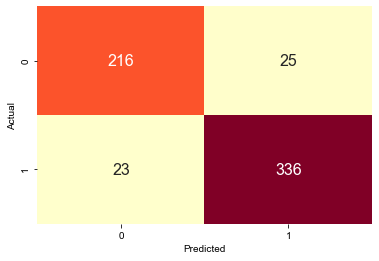

In [12]:
confusion_mat = confusion_matrix(y_test_auto,predict)
report = classification_report(y_test_auto, predict)
print("REPORT:\n{}".format(report))

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(confusion_mat, cmap='YlOrRd', annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16})
sn.set(font_scale= 1.5)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__c.1.2: Using Cross Validation__

In [13]:
#5 fold Cross validation so as to consider every review as a part of test data once and training dataset as k-1(4) times.
acc_scores = cross_val_score(clf_logReg, X_train_auto, y_train_auto, cv=5, scoring="accuracy")

#Represent the results as a Pandas Series
labels = [ "Fold %d->" % i for i in range(1,len(acc_scores)+1) ]
accuracies = pd.Series(acc_scores, index = labels)
print(accuracies)

#Mean accuracy of 5 folds
print("Mean accuracy-> %.4f" % accuracies.mean() )

Fold 1->    0.911032
Fold 2->    0.882562
Fold 3->    0.889286
Fold 4->    0.888889
Fold 5->    0.906810
dtype: float64
Mean accuracy-> 0.8957


__c.1.3: Using Repeated K folds__

In [14]:
#Evaluating performance using the RepeatedKFold.
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

#RepeatedKFold is passed as the parameter cv.
rep_acc_scores = cross_val_score(clf_logReg, X_train_auto, y_train_auto, cv=rkf, scoring="accuracy")

#Converting the results to Pandas Series.
rk_acc = pd.Series(rep_acc_scores)

#First 5 accuracies
rk_acc.head(5)

print("Overall mean accuracy:%.2f" %rk_acc.mean())
print("Overall standard deviation:%.2f" %rk_acc.std())

Overall mean accuracy:0.89
Overall standard deviation:0.02


#### Category 2: Hotels

In [15]:
#Creating the classifier
clf_logReg = LogisticRegression()
clf_logReg.fit(X_train_hotel, y_train_hotel)

#Predicting unseen data
predict = clf_logReg.predict(X_test_hotel)

#Checking accuracy score
acc = accuracy_score(predict, y_test_hotel)
print('TOTAL ACCURACY:{} \n'.format(acc*100))

TOTAL ACCURACY:88.66666666666667 



__c.2. Testing the predictions of the classification model on Hotels category.__

__c.2.1. Using confusion matrix.__

REPORT:
              precision    recall  f1-score   support

    negative       0.88      0.83      0.85       242
    positive       0.89      0.93      0.91       358

    accuracy                           0.89       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.89      0.89       600



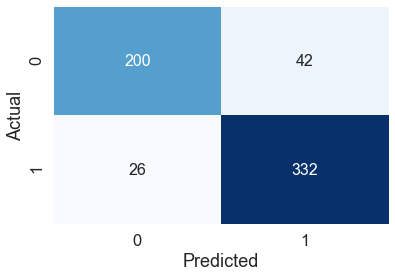

In [16]:
confusion_mat = confusion_matrix(y_test_hotel,predict)
report = classification_report(y_test_hotel, predict)
print("REPORT:\n{}".format(report))

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(confusion_mat, cmap='Blues', annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16})
sn.set(font_scale= 1.5)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__c.2.2: Using Cross Validation__

In [17]:
#5 fold Cross validation so as to consider every review as a part of test data once and training dataset as k-1(4) times.
acc_scores = cross_val_score(clf_logReg, X_train_hotel, y_train_hotel, cv=5, scoring="accuracy")

#Represent the results as a Pandas Series
labels = [ "Fold %d->" % i for i in range(1,len(acc_scores)+1) ]
accuracies = pd.Series(acc_scores, index = labels)
print(accuracies)

#Mean accuracy of 5 folds
print("Mean accuracy-> %.4f" % accuracies.mean() )

Fold 1->    0.875445
Fold 2->    0.914591
Fold 3->    0.907143
Fold 4->    0.878136
Fold 5->    0.881720
dtype: float64
Mean accuracy-> 0.8914


__c.2.3: Using Repeated K folds__

In [18]:
#Evaluating performance using the RepeatedKFold.
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

#RepeatedKFold is passed as the parameter cv.
rep_acc_scores = cross_val_score(clf_logReg, X_train_hotel, y_train_hotel, cv=rkf, scoring="accuracy")

#Converting the results to Pandas Series.
rk_acc = pd.Series(rep_acc_scores)

#First 5 accuracies
rk_acc.head(5)

print("Overall mean accuracy:%.2f" %rk_acc.mean())
print("Overall standard deviation:%.2f" %rk_acc.std())

Overall mean accuracy:0.89
Overall standard deviation:0.02


#### Category 3: Restaurants

In [19]:
#Creating the classifier
clf_logReg = LogisticRegression()
clf_logReg.fit(X_train_restaurant, y_train_restaurant)

#Predicting unseen data
predict = clf_logReg.predict(X_test_restaurant)

#Checking accuracy score
acc = accuracy_score(predict, y_test_restaurant)
print('TOTAL ACCURACY:{} \n'.format(acc*100))


TOTAL ACCURACY:60.83333333333333 



__c.3. Testing the predictions of the classification model on Restaurants category.__

__c.3.1: Using Confusion Matrix__

REPORT:
              precision    recall  f1-score   support

    negative       0.45      0.16      0.24       227
    positive       0.63      0.88      0.74       373

    accuracy                           0.61       600
   macro avg       0.54      0.52      0.49       600
weighted avg       0.56      0.61      0.55       600



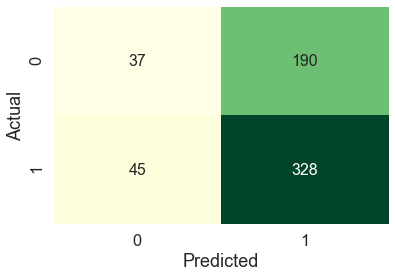

In [20]:
confusion_mat = confusion_matrix(y_test_restaurant,predict)
report = classification_report(y_test_restaurant, predict)
print("REPORT:\n{}".format(report))

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(confusion_mat, cmap='YlGn', annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16})
sn.set(font_scale= 1.5)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__c.3.2: Using Cross Validation__

In [21]:
#5 fold Cross validation so as to consider every review as a part of test data once and training dataset as k-1(4) times.
acc_scores = cross_val_score(clf_logReg, X_train_restaurant, y_train_restaurant, cv=5, scoring="accuracy")

#Represent the results as a Pandas Series
labels = [ "Fold %d->" % i for i in range(1,len(acc_scores)+1) ]
accuracies = pd.Series(acc_scores, index = labels)
print(accuracies)

#Mean accuracy of 5 folds
print("Mean accuracy-> %.4f" % accuracies.mean() )

Fold 1->    0.569395
Fold 2->    0.578571
Fold 3->    0.578571
Fold 4->    0.567857
Fold 5->    0.562724
dtype: float64
Mean accuracy-> 0.5714


__c.3.3: Using Repeated K folds__

In [22]:
#Evaluating performance using the RepeatedKFold.
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

#RepeatedKFold is passed as the parameter cv.
rep_acc_scores = cross_val_score(clf_logReg, X_train_restaurant, y_train_restaurant, cv=rkf, scoring="accuracy")

#Converting the results to Pandas Series.
rk_acc = pd.Series(rep_acc_scores)

#First 5 accuracies
rk_acc.head(5)

print("Overall mean accuracy:%.2f" %rk_acc.mean())
print("Overall standard deviation:%.2f" %rk_acc.std())

Overall mean accuracy:0.59
Overall standard deviation:0.03


### Task 3. 

__Evaluate the performance of each of your three classification models when applied to data from the other two selected categories. That is, for the selected categories (A,B,C), run the experiments:__

In [23]:
#Reading all categories into one dataframe for easy analysis
df_all = pd.DataFrame()
root = 'collected_data'
for root, directories, files in os.walk(root):
    for file in files:
        file_path = os.path.join(root,file)
        df_all = df_all.append(pd.read_csv(file_path),ignore_index=True)
df_all

,Reviews,Label
0,The man that was working tonight (8-12-17) was...,negative
1,Chris is a very rude person. Gave me an attitu...,negative
2,One of my favorite gas station to stop at. The...,positive
3,Oh thank Heaven for Seven Eleven! I don't know...,negative
4,Five stars because of the guy who works weekda...,positive
...,...,...
5995,"As a first timer ordering Zeppe's, this was an...",negative
5996,"We were also staying at the Fairfield Inn, and...",positive
5997,I was staying at the Fairfield Inn. Delivery w...,positive
5998,I drive 7 miles out of the way and past severa...,positive


==========================================================================================================================
__Pre-Processing:__

Following pre-processing steps are used on the data:

    1. Lemmatization
    2. Stopword removal
    3. Minimum document frequency
    4. TF-IDF Vectorization

In [24]:
all_documents = df_all['Reviews'].tolist()
all_targets = df_all['Label'].tolist()

#Initializing vectorizer and removing stop words and taking only those terms which occur in more than 10 documents(min_df=10)
vectorizer = TfidfVectorizer(stop_words="english",min_df=10) 

#Calculating tf-idf and creating a vector of terms.
X_all_reviews = vectorizer.fit_transform(all_documents)

#To visualize the data in tabular format.
df_tfidf = pd.DataFrame(X_all_reviews.todense(), columns =vectorizer.get_feature_names())
df_tfidf.head()

,00,000,10,100,1000,10am,11,110,11am,12,...,younger,yuck,yum,yummy,zach,zero,zone,zoo,zu,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.232394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.206762,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Shape of complete dataframe.
df_tfidf.shape

(6000, 3710)

__Since each category had 2000 records, I have seperated the categories using record numbers__

In [26]:
#Splitting again the complete tf-idf matrix into seperate dataframes.
df_automotive = df_tfidf.loc[0:1999,:]
df_automotive['Label'] = all_targets[:2000]

df_hotels = df_tfidf.loc[2000:3999,:]
df_hotels['Label'] = all_targets[2000:4000]

df_restaurants = df_tfidf.loc[4000:,:]
df_restaurants['Label'] = all_targets[4000:]


In [27]:
print('Hotels dataframe shape:',df_hotels.shape)
print('Restaurants dataframe shape:',df_restaurants.shape)
print('Automotive dataframe shape:',df_automotive.shape)

df_category_list = [df_automotive, df_hotels, df_restaurants]

Hotels dataframe shape: (2000, 3711)
Restaurants dataframe shape: (2000, 3711)
Automotive dataframe shape: (2000, 3711)


__Cross Category Evaluation__

* Training a classification model on the data from “Category Automotive”. Evaluating its performance on data from “Category Hotel” and data from “Category Restaurant”.

* Training a classification model on the data from “Category Hotels”. Evaluating its performance on data from “Category Automotive” and data from “Category Restaurants”.

* Training a classification model on the data from “Category Restaurants”. Evaluating its performance on data from “Category Automotive” and data from “Category Hotels”.

In [28]:
ring = {0:[1,2],1:[0,2],2:[0,1]}
category_list_name = ['Automotive', 'Hotels', 'Restaurants']
for i in range(len(ring)):
    #Training on one category
    X_train = df_category_list[i].iloc[:,:-1]
    y_train = df_category_list[i]['Label']
    
    #Testing on remaining categories
    for j in (ring[i]):
        X_test = df_category_list[j].iloc[:,:-1]
        y_test = df_category_list[j]['Label']

        clf_logReg = LogisticRegression()
        clf_logReg.fit(X_train, y_train)

        #Predicting unseen data
        predict = clf_logReg.predict(X_test)

        #Checking accuracy score
        acc_score = accuracy_score(predict, y_test)
        print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format(category_list_name[i],category_list_name[j],acc_score*100))

Accuracy when Training on "Automotive" and Testing on "Hotels"= 86.6%
Accuracy when Training on "Automotive" and Testing on "Restaurants"= 76.85%
Accuracy when Training on "Hotels" and Testing on "Automotive"= 87.25%
Accuracy when Training on "Hotels" and Testing on "Restaurants"= 82.55%
Accuracy when Training on "Restaurants" and Testing on "Automotive"= 80.25%
Accuracy when Training on "Restaurants" and Testing on "Hotels"= 85.5%


## CONCLUSION

* With the aid of BeautifulSoup, a huge amount of reviews from Automotive, Hotels and Restaurants was scrapped. Initially, all key links are retrieved using the fetch all feature of the scraper, from which the 3 chosen group links are placed in the list for further reference.

* For each main group, the request.get() method retrieves the links via the 'a' suffix. Further contents of the href tags are being fetched. In addition, for each category, all contents are scrapped using BeautifulSoup() and the reviews are collected using 'p' tags.

* Based on the number of ratings, the target class is chosen for each review and each review, along with its target class, is saved in a csv file. A number of pre-processing steps are also taken in the context of text reviews:
    * Lemmatization
    * Stop word removal
    * Minimum document frequency
    * TF-IDF
    
* After this the Logistic Regression model is built for each category and measures the success of each category via the Confusion matrix and portrays the incorrectly labeled reviews.

* Next, training the model for each category serving as a training dataset and checking its performance against the other two categories is evaluated.

* The Logistic Regression classification model appears to be the most powerful of the three classification models. Also, the efficiency of every model is measured using a variety of techniques such as confusion matrix, K Fold cross validation and Repeated fold cross validation.